In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
import pandas as pd

import scipy.integrate as integrate
import scipy.special as special

import random as random
import scipy.optimize as optimize

import importlib
import gc

In [65]:
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

In [119]:
import Functions_Xyloportas as f # All functions we will use

In [ ]:
# Update any changes in Functions_Xyloportas.py file
importlib.reload(f)
#help(f)

In [ ]:
gc.collect() # In case of "MemoryError"

#### Constants

In [120]:
# Parameters (Units: cgs)
st = 0.665245*(10**-24) # Thomson scattering cross section
c = 2.997925*(10**10) # speed of light
m = 9.10956*(10**-28) # mass of particles (electron)
q = 4.80325*(10**-10) # charge of particles (electron)
pi = math.pi

#A = (st*(B**2))/(6*np.pi*m*c)
#w_B = (q*B)/(m*c) # ω_B gyro-frequency
#tr = (gmax-gmin)/(A*gmax*gmin) #t_r (sec)

h = 6.625*10**-27 # Planck constant (erg*sec)
ev_to_erg = 1.602162*10**-12 # erg/eV
erg_to_ev = 1/ev_to_erg # eV/erg
kev_to_erg = ev_to_erg/(10**-3) # erg/keV
erg_to_kev = (10**-3)/ev_to_erg # keV/erg

print("1 erg = %0.2e keV" %erg_to_kev)
print("1 keV = %0.2e erg" %kev_to_erg)

1 erg = 6.24e+08 keV
1 keV = 1.60e-09 erg


Convert Units: keV to Hz <br>
$1 keV = 10^3 eV = 10^3 \cdot 1.602162 \cdot 10^{-12} erg $<br> 
$f(Hz) = E(erg) / h$

# GRB211211A

### Distance - Redshift

In [5]:
# import astropy.cosmology as cosmology
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18 as cosmo

In [6]:
r = 350 # Mpc

In [7]:
# Galaxy Redshift z
# z = 0.1 * cu.redshift
# d = z.to(u.Mpc, cu.redshift_distance(cosmo, kind="comoving")) 
d = r * u.Mpc # r Mpc
z = d.to(cu.redshift, cu.redshift_distance(cosmo, kind="comoving"))
print("z = %0.2e" %z)
print("1 + z = %0.2f" %(z+1))

z = 8.05e-02
1 + z = 1.08


Thus, redshift is very small (z=0.08) and can be ignored. We will focus only on the Doppler factor, due to the jet's speed: <br>
Relativistic transformations: <br>
$\nu_{obs} = D \cdot \nu_{rest} $<br> 
$J_{syn,obs} = D^3 \cdot J_{syn,rest}$ <br> 
$t_{obs} = t_{rest}/D$

## 1. Observational data 

Data from $\href{https://arxiv.org/pdf/2205.05008}{B.P.Gompertz \ et \ al. \ 2022}$

### **a. Spectral energy distribution $\nu \cdot F_\nu$**

In [9]:
# Example: Time-bin (0-2)sec
dataGRB0002 = pd.read_csv('./data/0-2s.txt', delimiter='\t')
e0002 = dataGRB0002["keV"] # energy (keV)
e0002er = 0.5*dataGRB0002["keVe"] # energy error (keV) [keVe = range of energy bin]
f0002 = dataGRB0002["f"] # flux (keV/s*cm^2)
f0002er = dataGRB0002["fe"] # flux error (keV/s*cm^2)
mod0002 = dataGRB0002["mod"] # Model from Paper (keV/s*cm^2)
print(dataGRB0002)

            keV       keVe           f          fe         mod
0     12.359500   1.540500   76.889770   15.090273  105.598289
1     14.992000   1.092000  135.483490   19.682396  130.269958
2     17.327499   1.243500  155.691254   20.059725  150.526230
3     19.959000   1.388000  132.539032   19.806198  171.698944
4     22.055500   0.708500  183.976456   32.108398  188.585266
..          ...        ...         ...         ...         ...
162   95.250000   3.550003  379.408997   61.263264  453.525299
163  102.400002   3.599998  532.219971   79.991303  471.940125
164  109.650002   3.650002  488.223602   89.782875  490.711884
165  120.800003   7.500000  405.692780   78.247444  516.461426
166  138.550003  10.250000  496.497131  107.287140  556.264465

[167 rows x 5 columns]


In [12]:
# Import observational data, from all timeframes
timeframes = [(0,2), (6,8), (10,12), (18,20), (30,34), (50,60)]
GRB_data = [0]*len(timeframes) # data (units: keV,keV/s*cm^2)
GRB_dataCGS = [0]*len(timeframes)  # data (cgs units: Hz,erg/s*cm^2)
for q in range(len(timeframes)):
    GRB_data[q] = np.loadtxt('./data/{}-{}s.txt'.format(timeframes[q][0], timeframes[q][1]), unpack=True, skiprows=1)
    GRB_dataCGS[q] = np.loadtxt('./data/{}-{}s.txt'.format(timeframes[q][0], timeframes[q][1]), unpack=True, skiprows=1)
print(GRB_data[0][4][0]) # [timeframe][parameter][value]

105.598289


In [13]:
# Energy (keV to Hz) , Flux (keV to erg/s*cm^2)
for q in range(len(timeframes)):
    GRB_dataCGS[q][0] = GRB_dataCGS[q][0]*kev_to_erg/h # keV to Hz (keV)
    GRB_dataCGS[q][1] = GRB_dataCGS[q][1]*kev_to_erg/h # keV to Hz (keVe)
    GRB_dataCGS[q][2] = GRB_dataCGS[q][2]*kev_to_erg   # keV/s*cm^2 to erg/s*cm^2 (f)
    GRB_dataCGS[q][3] = GRB_dataCGS[q][3]*kev_to_erg   # keV/s*cm^2 to erg/s*cm^2 (fe)
    GRB_dataCGS[q][4] = GRB_dataCGS[q][4]*kev_to_erg   # keV/s*cm^2 to erg/s*cm^2 (mod)

In [21]:
# Energy/Frequency range
for i in range(len(timeframes)):
    print("t = ", timeframes[i],"s")
    print("E_min = %0.3e Hz" %min(GRB_dataCGS[i][0]), " = %0.3f keV" %min(GRB_data[i][0]))
    print("E_max = %0.3e Hz" %max(GRB_dataCGS[i][0]), " = %0.3f keV" %max(GRB_data[i][0]))

t =  (0, 2) s
E_min = 2.674e+18 Hz  = 11.059 keV
E_max = 2.291e+21 Hz  = 9474.637 keV
t =  (6, 8) s
E_min = 2.544e+18 Hz  = 10.521 keV
E_max = 2.106e+21 Hz  = 8707.549 keV
t =  (10, 12) s
E_min = 2.544e+18 Hz  = 10.521 keV
E_max = 2.079e+21 Hz  = 8596.346 keV
t =  (18, 20) s
E_min = 2.544e+18 Hz  = 10.521 keV
E_max = 2.258e+21 Hz  = 9335.699 keV
t =  (30, 34) s
E_min = 2.544e+18 Hz  = 10.521 keV
E_max = 2.079e+21 Hz  = 8596.346 keV
t =  (50, 60) s
E_min = 2.544e+18 Hz  = 10.521 keV
E_max = 2.164e+21 Hz  = 8946.609 keV


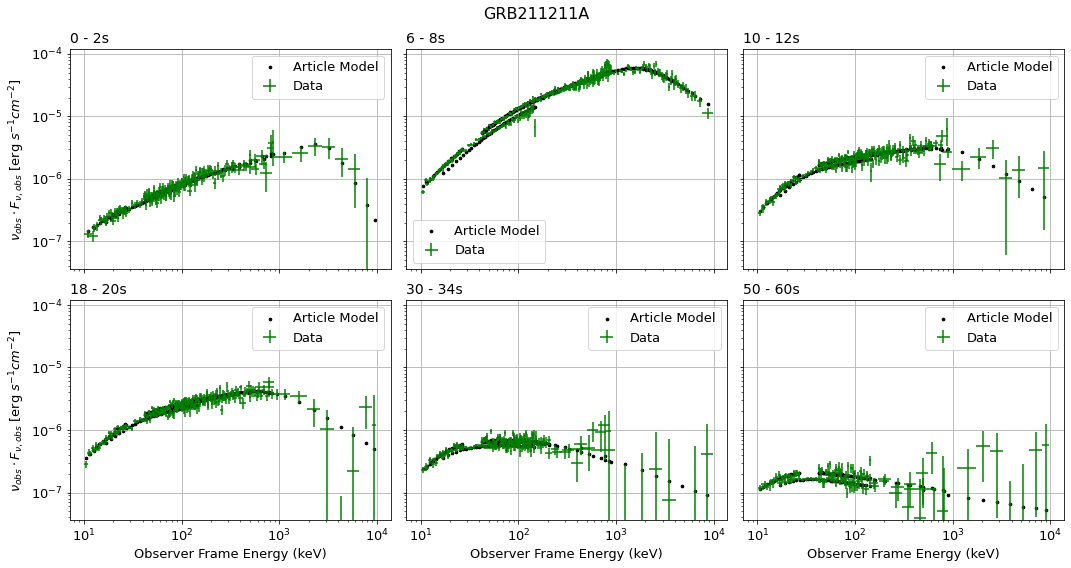

In [27]:
# Plot data
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_size_inches(15,8)
fig.suptitle('GRB211211A', fontsize=16)

for q in range(len(timeframes)):
    ax[q//3, q-(q//3)*3].errorbar(GRB_data[q][0],GRB_dataCGS[q][2],xerr=GRB_data[q][1],yerr=GRB_dataCGS[q][3], fmt='none', elinewidth=1.5, c='g', label="Data")
    ax[q//3, q-(q//3)*3].scatter(GRB_data[q][0],GRB_dataCGS[q][4], marker='o', s=7, c='k', label="Article Model")
    ax[q//3, q-(q//3)*3].set_yscale("log")
    ax[q//3, q-(q//3)*3].set_xscale("log")
    ax[q//3, q-(q//3)*3].grid()
    ax[q//3, q-(q//3)*3].legend(fontsize=13)
    ax[q//3, q-(q//3)*3].set_title('{} - {}s'.format(timeframes[q][0], timeframes[q][1]), loc='left', fontsize=14)
    ax[q//3, q-(q//3)*3].tick_params(axis='both', which='major', labelsize=13)

for ax in ax.flat:
    ax.set_xlabel('Observer Frame Energy (keV)', fontsize=13)
    ax.set_ylabel(r'$\nu_{obs} \cdot F_{\nu,obs}}$ [erg $s^{-1} cm^{-2}$]', fontsize=13)
    
for ax in fig.get_axes():
    ax.label_outer()

fig.tight_layout()
#plt.savefig('GRB211211A_Spectra.png')

### **b. Spectral Breaks energy $E_p(t)$ & $E_b(t)$**

Derived from time-resolved spectral fitting with the 2SBPL Model (synchrotron spectrum, 3 power-law segments) <br>
Table 1, $\href{https://arxiv.org/pdf/2205.05008}{B.P.Gompertz \ et \ al. \ 2022}$

In [121]:
# Import Spectral Breaks
SpectralBreaksA = pd.read_csv('./SpectralBreaks/SpBrA.txt', delimiter='\t') # t<40s
print(SpectralBreaksA)
TimeA = SpectralBreaksA["Time"] # sec
TimeerA = SpectralBreaksA["Timeer"] # sec
EbA = SpectralBreaksA["Eb"] # keV
EberA = SpectralBreaksA["Eber"] # keV
EpA = SpectralBreaksA["Ep"] # keV
EperA = SpectralBreaksA["Eper"] # keV

SpectralBreaksB = pd.read_csv('./SpectralBreaks/SpBrB.txt', delimiter='\t') # t>40s
print(SpectralBreaksB)
TimeB = SpectralBreaksB["Time"] # sec
TimeerB = SpectralBreaksB["Timeer"] # sec
EpB = SpectralBreaksB["Ep"] # keV
EperB = SpectralBreaksB["Eper"] # keV

    Time  Timeer    Eb  Eber      Ep   Eper
0    1.0     1.0  21.0   8.8  2411.3  602.0
1    3.0     1.0  46.7   8.2   951.6   47.4
2    5.0     1.0  30.7   3.3   721.0   47.5
3    7.0     1.0  64.3   4.9  1543.0   47.5
4    9.0     1.0  30.0   2.7  1053.6   72.0
5   11.0     1.0  28.5   2.4   567.1  135.7
6   14.0     2.0  19.9   3.6   257.3  205.7
7   17.0     1.0  20.6   4.2   275.0   40.9
8   19.0     1.0  27.2   2.8   580.0   86.5
9   21.0     1.0  23.8   2.9   319.6   45.8
10  23.0     1.0  24.2   2.6   335.2   51.5
11  25.0     1.0  24.8   2.7   305.5   47.9
12  28.0     2.0  24.3   0.9    83.9   30.3
13  32.0     2.0  17.2   3.7    69.8   16.9
14  36.0     2.0  20.2   1.6   225.6   50.9
15  40.0     2.0  17.6   4.2    76.3   15.9
     Time  Timeer     Ep  Eper
0    44.0     2.0  37.70  3.06
1    48.0     2.0  42.20  5.61
2    55.0     5.0  35.50  2.29
3    65.0     5.0  36.40  4.32
4    85.0     5.0   7.74  0.81
5    95.0     5.0   5.81  0.83
6   105.0     5.0   4.59  0.54
7   

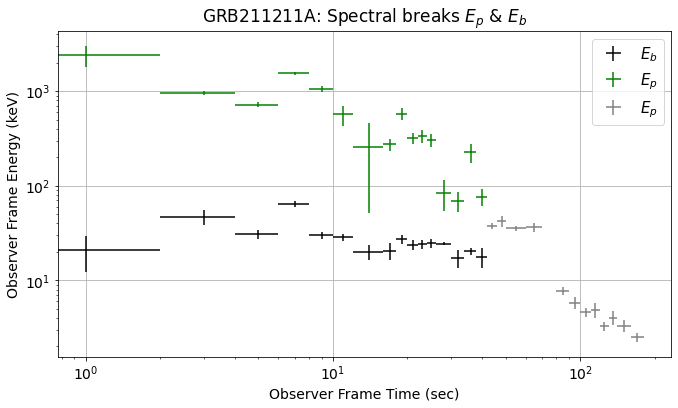

In [32]:
# Plot temporal evolution of Spectral Breaks
figSB = plt.figure(figsize=(11,6))
plt.grid()
plt.xlabel("Observer Frame Time (sec)", fontsize=14)
plt.ylabel("Observer Frame Energy (keV)", fontsize=14)
plt.title("GRB211211A: Spectral breaks $E_p$ & $E_b$", fontsize=17)
plt.yscale("log")
plt.xscale("log")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.errorbar(TimeA,EbA,xerr=TimeerA,yerr=EberA, fmt='none', elinewidth=1.5, c='k', label="$E_b$")
plt.errorbar(TimeA,EpA,xerr=TimeerA,yerr=EperA, fmt='none', elinewidth=1.5, c='g', label="$E_p$")
plt.errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', elinewidth=1.5, c='0.5', label="$E_p$")
plt.legend(fontsize=15)
#plt.savefig('GRB211211A_SpectralBreaks.png')

In [36]:
# timeframes = [(0,2), (6,8), (10,12), (18,20), (30,34), (50,60)]
Ep_array = [EpA[0],EpA[3],EpA[5],EpA[8],EpA[13],EpB[2]]
Eb_array = [EbA[0],EbA[3],EbA[5],EbA[8],EbA[13],0]

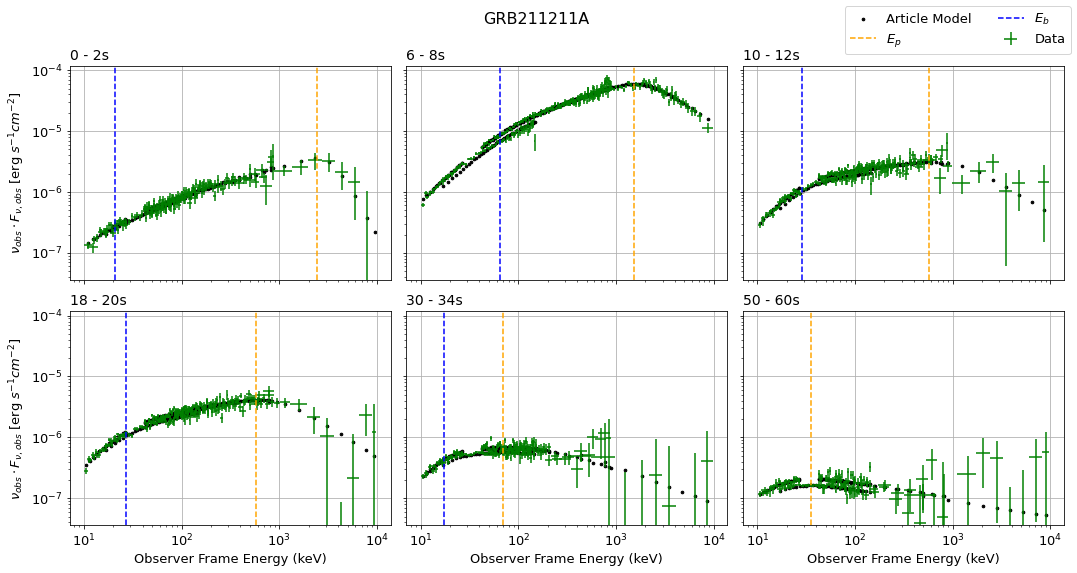

In [64]:
# GRB spectra, with Spectral Breaks included
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_size_inches(15,8)
fig.suptitle('GRB211211A', fontsize=16)

for q in range(len(timeframes)):
    ax[q//3, q-(q//3)*3].errorbar(GRB_data[q][0],GRB_dataCGS[q][2],xerr=GRB_data[q][1],yerr=GRB_dataCGS[q][3], fmt='none', elinewidth=1.5, c='g', label="Data")
    ax[q//3, q-(q//3)*3].scatter(GRB_data[q][0],GRB_dataCGS[q][4], marker='o', s=7, c='k', label="Article Model")
    ax[q//3, q-(q//3)*3].axvline(x=Ep_array[q],linestyle="--",c='orange', label="$E_p$") # E_p
    ax[q//3, q-(q//3)*3].axvline(x=Eb_array[q],linestyle="--",c='b', label="$E_b$") # E_b
    ax[q//3, q-(q//3)*3].set_yscale("log")
    ax[q//3, q-(q//3)*3].set_xscale("log")
    ax[q//3, q-(q//3)*3].grid()
    #ax[q//3, q-(q//3)*3].legend(fontsize=13)
    ax[q//3, q-(q//3)*3].set_title('{} - {}s'.format(timeframes[q][0], timeframes[q][1]), loc='left', fontsize=14)
    ax[q//3, q-(q//3)*3].tick_params(axis='both', which='major', labelsize=13)

# Add a single legend for the entire figure
handles, labels = ax.flat[0].get_legend_handles_labels()  # Get handles and labels from one subplot
fig.legend(handles, labels, loc='upper right', ncol=2, fontsize=13, frameon=True)

for ax in ax.flat:
    ax.set_xlabel('Observer Frame Energy (keV)', fontsize=13)
    ax.set_ylabel(r'$\nu_{obs} \cdot F_{\nu,obs}}$ [erg $s^{-1} cm^{-2}$]', fontsize=13)
    
for ax in fig.get_axes():
    ax.label_outer()

#fig.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend
#plt.savefig('GRB211211A_Complete_Spectra.png')

## 2. Spectral Breaks fit 

**scipy.optimize.curve_fit** : Non-linear least squares fit

Each break energy $E_{obs}$ (in the observer frame) is related to a Lorentz factor γ, with the following equation:

$E_{obs} = δ \cdot E_{rest} = δ \cdot h \nu_{max} = δ \cdot h \dfrac{ω_B \, γ^2}{2π} = δh\dfrac{qB}{2πmc} γ^2 $

$E_{obs}$ is in $erg$, thus: convert units <br> 
$1 keV = 10^3 eV = 10^3 \cdot 1.602162 \cdot 10^{-12} erg $<br> 
$f(Hz) = E(erg) / h $

1 erg = ''erg_to_kev'' keV  <br> 
1 keV = ''kev_to_erg'' erg

We have 2 spectral breaks: $E_p$ and $E_b$. <br>
The spectrum from time-constant injection of power-law electrons has 3 spectral breaks, which correspond to $γ_{max}$, $γ_{max}(t)$ and $γ_{min}$. <br>
$γ_{min}(t)$ is very close to $γ_{min}$ (for $t < t_r$) or to $γ_{max}(t)$ (for $t > t_r$), thus it is not important here.

We relate $E_p$ and $E_b$ to $γ_{max}(t)$ and $γ_{min}$ respectively, for $ t \leq 40s$. <br> However we will also examine the case of $γ_{max}(t)$ and $γ_{min}(t)$ as the Lorentz factors behind the spectral breaks.

In [86]:
# γ -> E_{obs} (keV)
def Eobs_fromg(g,D,B):
    E = D*h*q*B*(g**2)/(2*math.pi*m*c) # E_{obs}(erg)
    return E*erg_to_kev # E_{obs}(keV)
# E_{obs} (keV) -> γ 
def g_fromEobs(E,D,B):
    Eerg = E*kev_to_erg # E_{obs}(erg)
    return (2*math.pi*m*c*E/(D*h*q*B))**0.5 # γ

In [97]:
# Functions for fits [Input: (t,[γ_o,D,B]) , Ouput (E_obs)]

def fit_E_gt(tobs,go,BB,DD): # t = independent variable (t_obs)
    t = tobs*DD # t_obs = t_rest/D
    gg = f.g_evolutionB(go,t,BB) # = go/(1+((st*BB**2)/(6*m*c*pi))*go*t) = go/(1+A*go*t)    [γ(t)]
    # E = DD*h*(q*BB/(m*c))*(gg**2)/(2*pi) # E_obs (erg) = E_rest*D
    # E = DD*(q*BB/(m*c))*(gg**2)/(2*pi) # v_obs (Hz) = E_obs(erg)/h
    # E*erg_to_kev # E_obs (keV)
    return Eobs_fromg(gg,DD,BB) # E_obs (keV)
# OR SIMPLY
# def fit_E_gt2(tobs,go,BB,DD): # t = independent variable (t_obs = t_rest/D)
#     #E = DD*h*(q*BB/(2*pi*m*c))*((go/(1+((st*go*tobs*DD*BB**2)/(6*m*c*pi))))**2) # E_obs (erg) = E_rest*D
#     return erg_to_kev*DD*h*(q*BB/(2*pi*m*c))*((go/(1+((st*go*tobs*DD*BB**2)/(6*m*c*pi))))**2) # E_obs (keV)

# Ε_b = constant (γ_max OR γ_min)
def fit_E_const(tobs,go): # t = independent variable
    BB = paramB
    DD = paramD
    return erg_to_kev*DD*h*(q*BB/(2*pi*m*c))*(go**2) # E_obs (keV)

### **Step 1:** Fit $E_p$ for $γ_{max}(t)$

In [89]:
# Fit for every parameter

# Without bounds
poptmaxBD,pcovmaxBD = optimize.curve_fit(fit_E_gt, TimeA, EpA, sigma=EperA, p0=[10**6,0.5,300])
print(poptmaxBD)
print(pcovmaxBD)
print(np.diag(pcovmaxBD))
print("γ_max = %0.3e" %poptmaxBD[0], "+- %0.3e" %(np.sqrt(np.diag(pcovmaxBD))[0]))
print("B = (%0.3f" %poptmaxBD[1], "+- %0.3f) G" %(np.sqrt(np.diag(pcovmaxBD))[1]))
print("D = %0.1f" %poptmaxBD[2], "+- %0.1f" %(np.sqrt(np.diag(pcovmaxBD))[2]))

[1.12713317e+06 4.07068690e-01 2.95380782e+02]
[[ 5.84981879e+24  2.11268569e+18 -4.59907690e+21]
 [ 2.11268569e+18  7.63004972e+11 -1.66097520e+15]
 [-4.59907690e+21 -1.66097520e+15  3.61575446e+18]]
[5.84981879e+24 7.63004972e+11 3.61575446e+18]
γ_max = 1.127e+06 +- 2.419e+12
B = (0.407 +- 873501.558) G
D = 295.4 +- 1901513727.3


In [90]:
# With bounds
poptmaxBD,pcovmaxBD = optimize.curve_fit(fit_E_gt, TimeA, EpA, sigma=EperA, p0=[10**6,0.5,300], bounds=([10**5,0.1,100], [10**7,10.0,1000]))
print(poptmaxBD)
print(pcovmaxBD)
print(np.diag(pcovmaxBD))
print("γ_max = %0.3e" %poptmaxBD[0], "+- %0.3e" %(np.sqrt(np.diag(pcovmaxBD))[0]))
print("B = (%0.3f" %poptmaxBD[1], "+- %0.3f) G" %(np.sqrt(np.diag(pcovmaxBD))[1]))
print("D = %0.1f" %poptmaxBD[2], "+- %0.1f" %(np.sqrt(np.diag(pcovmaxBD))[2]))
g_max_fit1 = poptmaxBD[0]
g_max_fit1er = np.sqrt(np.diag(pcovmaxBD))[0]
B_fit1 = poptmaxBD[1]
B_fit1er = np.sqrt(np.diag(pcovmaxBD))[1]
D_fit1 = poptmaxBD[2]
D_fit1er = np.sqrt(np.diag(pcovmaxBD))[2]

[1.13521168e+06 4.09987750e-01 2.89125395e+02]
[[ 3.79702722e+25  1.37131664e+19 -2.90117774e+22]
 [ 1.37131664e+19  4.95258323e+12 -1.04777582e+16]
 [-2.90117774e+22 -1.04777582e+16  2.21669000e+19]]
[3.79702722e+25 4.95258323e+12 2.21669000e+19]
γ_max = 1.135e+06 +- 6.162e+12
B = (0.410 +- 2225440.009) G
D = 289.1 +- 4708173742.2


Even if we try to "restrict" the range for the parameters, the do not converge to reasonable standard errors.<br>
We will try again this fit, now with one parameter fixed to a (random) value.

In [91]:
# Fit, if we know one parameter (here it is δ)
def fit_E_gt_knowD(tobs,go,BB): # t = independent variable (t_obs = t_rest/D)
    DD = D_hyp
    return fit_E_gt(tobs,go,BB,DD) # E_obs (keV)

In [92]:
# Know one parameter, i.e δ
D_hyp = 300
# Without bounds
poptmaxB,pcovmaxB = optimize.curve_fit(fit_E_gt_knowD, TimeA, EpA, sigma=EperA, p0=[10**6,0.5])
print(poptmaxB)
print(pcovmaxB)
print(np.diag(pcovmaxBD))
print("γ_max = %0.3e" %poptmaxB[0], "+- %0.3e" %(np.sqrt(np.diag(pcovmaxB))[0]))
print("B = (%0.3f" %poptmaxB[1], "+- %0.3f) G" %(np.sqrt(np.diag(pcovmaxB))[1]))

[1.12132697e+06 4.04974418e-01]
[[1.09636815e+10 1.13207757e+03]
 [1.13207757e+03 4.49693883e-03]]
[3.79702722e+25 4.95258323e+12 2.21669000e+19]
γ_max = 1.121e+06 +- 1.047e+05
B = (0.405 +- 0.067) G


Here the fit coverge, we get reasonable errors!

### **Step 2a:** Fit $E_b$ for $γ_{min}$ 

In [101]:
# Fit γ_min [with parameters from γ_max(t) fit]
paramB = B_fit1
paramD = D_fit1
print("We use: B = (%0.3f" %B_fit1, "+- %0.3f) G" %B_fit1er)
print("We use: D = (%0.1f" %D_fit1, "+- %0.1f)" %D_fit1er)

poptmin0,pcovmin0 = optimize.curve_fit(fit_E_const, TimeA, EbA, sigma=EberA, p0=[10**5])
# print(poptminB)
# print(pcovminB)
print("γ_min = %0.3e" %poptmin0[0], "+- %0.3e" %(np.sqrt(np.diag(pcovmin0))[0]))
gmin0_fit1 = poptmin0[0]
gmin0_fit1er = np.sqrt(np.diag(pcovmin0))[0]

We use: B = (0.410 +- 2225440.009) G
We use: D = (289.1 +- 4708173742.2)
γ_min = 1.344e+05 +- 4.139e+03


### **Step 2b:** Fit $E_b$ for $γ_{min}(t)$

In [102]:
# Fit γ_min(t) for every parameter
# With bounds
poptminBD,pcovminBD = optimize.curve_fit(fit_E_gt, TimeA, EbA, sigma=EberA, p0=[10**5,0.5,300], bounds=([10**4,0.1,100], [10**6,10.0,1000]))
print(poptminBD)
print(pcovminBD)
print(np.diag(pcovminBD))
print("γ_min = %0.3e" %poptminBD[0], "+- %0.3e" %(np.sqrt(np.diag(pcovminBD))[0]))
print("B = (%0.3f" %poptminBD[1], "+- %0.3f) G" %(np.sqrt(np.diag(pcovminBD))[1]))
print("D = %0.1f" %poptminBD[2], "+- %0.1f" %(np.sqrt(np.diag(pcovminBD))[2]))
g_min_fit2 = poptminBD[0]
g_min_fit2er = np.sqrt(np.diag(pcovminBD))[0]
B_fit2 = poptminBD[1]
B_fit2er = np.sqrt(np.diag(pcovminBD))[1]
D_fit2 = poptminBD[2]
D_fit2er = np.sqrt(np.diag(pcovminBD))[2]

[1.63396263e+05 3.75163657e-01 3.20178349e+02]
[[ 5.40299727e+22  1.24054747e+17 -3.17618541e+20]
 [ 1.24054747e+17  2.84834130e+11 -7.29263514e+14]
 [-3.17618541e+20 -7.29263514e+14  1.86714027e+18]]
[5.40299727e+22 2.84834130e+11 1.86714027e+18]
γ_min = 1.634e+05 +- 2.324e+11
B = (0.375 +- 533698.538) G
D = 320.2 +- 1366433411.4


In [103]:
# Fit γ_min(t) [with parameters B,D from γ_max(t) fit]
def fit_E_gt_knowBD(tobs,go): # t = independent variable (t_obs = t_rest/D)
    DD = D_hyp
    BB = B_hyp
    return fit_E_gt(tobs,go,BB,DD) # E_obs (keV)

In [106]:
# Fit γ_min(t) [with parameters from γ_max(t) fit]
D_hyp = D_fit1
B_hyp = B_fit1
print("We use: B = (%0.3f" %B_fit1, "+- %0.3f) G" %B_fit1er)
print("We use: D = (%0.1f" %D_fit1, "+- %0.1f)" %D_fit1er)

poptmin_knowBD,pcovmin_knowBD = optimize.curve_fit(fit_E_gt_knowBD, TimeA, EbA, sigma=EberA, p0=[10**5])
# print(poptmin_knowBD)
# print(pcovmin_knowBD)
print(np.diag(pcovmin_knowBD))
print("γ_min = %0.3e" %poptmin_knowBD[0], "+- %0.3e" %(np.sqrt(np.diag(pcovmin_knowBD))[0]))
g_min_fit1 = poptmin_knowBD[0]
g_min_fit1er = np.sqrt(np.diag(pcovmin_knowBD))[0]

We use: B = (0.410 +- 2225440.009) G
We use: D = (289.1 +- 4708173742.2)
[23496185.31025049]
γ_min = 1.672e+05 +- 4.847e+03


**Plots**<br>
Here we do not plot the errors of the parameters, because the fits don't converge.

In [108]:
# Plot results γ_max(t) & γ_min(t)
print("B = (%0.3f" %B_fit1, "+- %0.3f) G" %D_fit1er)
print("D = %0.1f" %D_fit1, "+- %0.1f" %D_fit1er)
print("γ_max = %0.3f" %g_max_fit1, "+- %0.3f" %g_max_fit1er)
print("γ_min = %0.1f" %g_min_fit1, "+- %0.1f" %g_min_fit1er)

t_obs = np.logspace(0,2.3,100) # t_obs (1s - 200s)
t = t_obs*D_fit1 # t_rest = t_obs*D
Gmax_array = [fit_E_gt(x,g_max_fit1,B_fit1,D_fit1) for x in t_obs] 
Gmin_array = [fit_E_gt(x,g_min_fit1,B_fit1,D_fit1) for x in t_obs] 

B = (0.410 +- 4708173742.195) G
D = 289.1 +- 4708173742.2
γ_max = 1135211.678 +- 6162002289769.062
γ_min = 167195.1 +- 4847.3


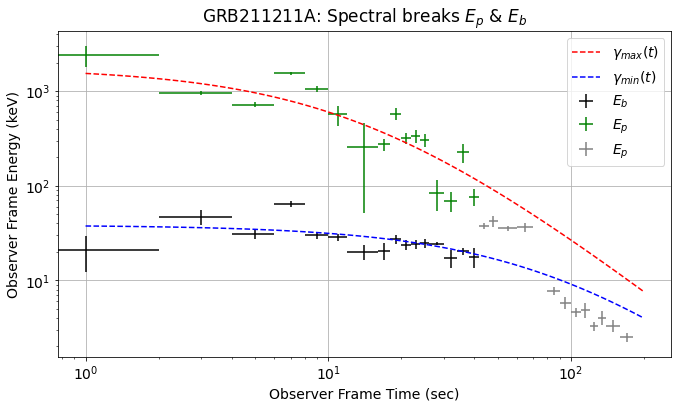

In [110]:
figSCIPY1 = plt.figure(figsize=(11,6))
plt.grid()
plt.xlabel("Observer Frame Time (sec)", fontsize=14)
plt.ylabel("Observer Frame Energy (keV)", fontsize=14)
plt.title("GRB211211A: Spectral breaks $E_p$ & $E_b$", fontsize=17)
plt.yscale("log")
plt.xscale("log")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.errorbar(TimeA,EbA,xerr=TimeerA,yerr=EberA, fmt='none', elinewidth=1.5, c='k', label="$E_b$")
plt.errorbar(TimeA,EpA,xerr=TimeerA,yerr=EperA, fmt='none', elinewidth=1.5, c='g', label="$E_p$")
plt.errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', elinewidth=1.5, c='0.5', label="$E_p$")
plt.plot(t_obs,Gmax_array, "r--", label="$γ_{max} (t)$")
plt.plot(t_obs,Gmin_array, "b--", label="$γ_{min} (t)$")
plt.legend(fontsize=14)
#plt.savefig('GRB211211A_SpectralBreaks_scipyfit1.png')

In [113]:
# plot result γ_max(t) & γ_min
print("B = (%0.3f" %B_fit1, "+- %0.3f) G" %D_fit1er)
print("D = %0.1f" %D_fit1, "+- %0.1f" %D_fit1er)
print("γ_max = %0.3f" %g_max_fit1, "+- %0.3f" %g_max_fit1er)
print("γ_min = %0.1f" %gmin0_fit1, "+- %0.1f" %gmin0_fit1er)

t_obs = np.logspace(0,2.3,100) # t_obs (1s - 200s)
t = t_obs*D_fit1 # t_rest = t_obs*D
Gmax_array0 = [fit_E_gt(x,g_max_fit1,B_fit1,D_fit1) for x in t_obs] 
Gmin0 = [Eobs_fromg(gmin0_fit1,D_fit1,B_fit1) for x in t_obs] 

B = (0.410 +- 4708173742.195) G
D = 289.1 +- 4708173742.2
γ_max = 1135211.678 +- 6162002289769.062
γ_min = 134372.0 +- 4139.4


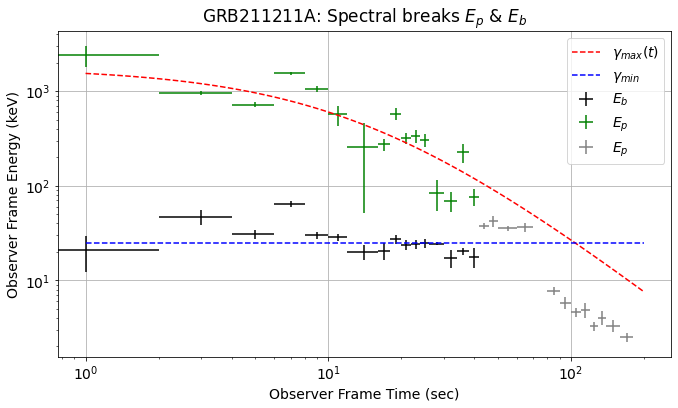

In [115]:
figSCIPY2 = plt.figure(figsize=(11,6))
plt.grid()
plt.xlabel("Observer Frame Time (sec)", fontsize=14)
plt.ylabel("Observer Frame Energy (keV)", fontsize=14)
plt.title("GRB211211A: Spectral breaks $E_p$ & $E_b$", fontsize=17)
plt.yscale("log")
plt.xscale("log")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.errorbar(TimeA,EbA,xerr=TimeerA,yerr=EberA, fmt='none', elinewidth=1.5, c='k', label="$E_b$")
plt.errorbar(TimeA,EpA,xerr=TimeerA,yerr=EperA, fmt='none', elinewidth=1.5, c='g', label="$E_p$")
plt.errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', elinewidth=1.5, c='0.5', label="$E_p$")
plt.plot(t_obs,Gmax_array0, "r--", label="$γ_{max} (t)$")
plt.plot(t_obs,Gmin0, "b--", label="$γ_{min}$")
plt.legend(fontsize=14)
#plt.savefig('GRB211211A_SpectralBreaks_scipyfit2.png')

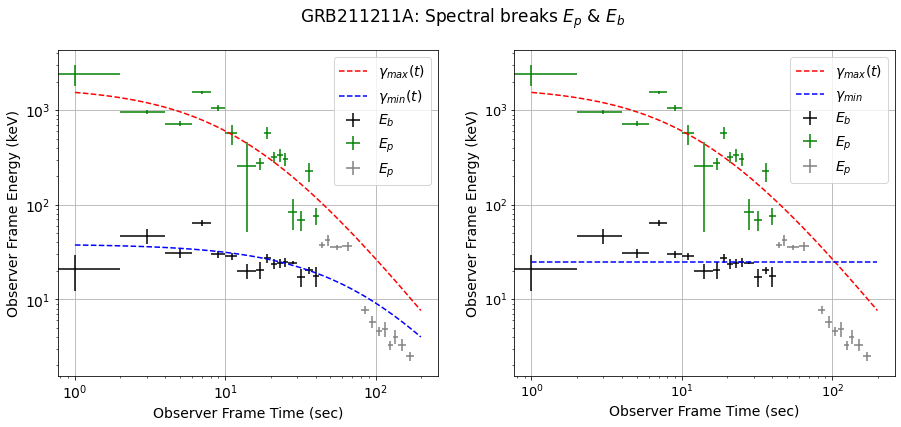

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle("GRB211211A: Spectral breaks $E_p$ & $E_b$", fontsize=17)
axes[0].set_xlabel("Observer Frame Time (sec)", fontsize=14)
axes[0].set_ylabel("Observer Frame Energy (keV)", fontsize=14)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid()
axes[1].set_xlabel("Observer Frame Time (sec)", fontsize=14)
axes[1].set_ylabel("Observer Frame Energy (keV)", fontsize=14)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].tick_params(axis='both', which='major', labelsize=13)
axes[1].grid()

axes[0].errorbar(TimeA,EbA,xerr=TimeerA,yerr=EberA, fmt='none', elinewidth=1.5, c='k', label="$E_b$")
axes[0].errorbar(TimeA,EpA,xerr=TimeerA,yerr=EperA, fmt='none', elinewidth=1.5, c='g', label="$E_p$")
axes[0].errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', elinewidth=1.5, c='0.5', label="$E_p$")
axes[0].plot(t_obs,Gmax_array, "r--", label="$γ_{max} (t)$")
axes[0].plot(t_obs,Gmin_array, "b--", label="$γ_{min} (t)$")
axes[1].errorbar(TimeA,EbA,xerr=TimeerA,yerr=EberA, fmt='none', elinewidth=1.5, c='k', label="$E_b$")
axes[1].errorbar(TimeA,EpA,xerr=TimeerA,yerr=EperA, fmt='none', elinewidth=1.5, c='g', label="$E_p$")
axes[1].errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', elinewidth=1.5, c='0.5', label="$E_p$")
axes[1].plot(t_obs,Gmax_array0, "r--", label="$γ_{max} (t)$")
axes[1].plot(t_obs,Gmin0, "b--", label="$γ_{min}$")

axes[0].legend(fontsize=14)
axes[1].legend(fontsize=14)
#plt.savefig('GRB211211A_SpectralBreaks_scipyfit12.png')

### **Step 3:** Study correlation between the parameters

In [122]:
D_array = np.linspace(50,2000,50) # D values
# def fit_E_gt_knowD(tobs,go,BB): # t = independent variable (t_obs = t_rest/D)
#     DD = D_hyp
#     return fit_E_gt(tobs,go,BB,DD) # E_obs (keV)

# γ_max(t)
poptmaxB_array = [0]*len(D_array)
pcovmaxB_array = [0]*len(D_array)
Bmax_i = [0]*len(D_array) # B(D)
Bmaxer_i = [0]*len(D_array)
gmax_i = [0]*len(D_array) # γ_max(D)
gmaxer_i = [0]*len(D_array)
for i in range(len(D_array)):
    D_hyp = D_array[i]
    poptmaxB_array[i],pcovmaxB_array[i] = optimize.curve_fit(fit_E_gt_knowD, TimeA, EpA, sigma=EperA, p0=[10**6,0.5])
    gmax_i[i] = poptmaxB_array[i][0]
    gmaxer_i[i] = np.sqrt(np.diag(pcovmaxB_array[i]))[0]
    Bmax_i[i] = poptmaxB_array[i][1]
    Bmaxer_i[i] = np.sqrt(np.diag(pcovmaxB_array[i]))[1]
    #print(poptmaxB_array[i])
    #print(pcovmaxB_array[i])
    #print("γ_max = %0.3e" %gmax_i[i], "+- %0.3e" %gmaxer_i[i])
    #print("B = (%0.3f" %Bmax_i[i], "+- %0.3f) G" %Bmaxer_i[i])

# γ_min(t)
poptminB_array = [0]*len(D_array)
pcovminB_array = [0]*len(D_array)
Bmin_i = [0]*len(D_array) # B(D)
Bminer_i = [0]*len(D_array)
gmin_i = [0]*len(D_array) # γ_min(D)
gminer_i = [0]*len(D_array)
for i in range(len(D_array)):
    D_hyp = D_array[i]
    poptminB_array[i],pcovminB_array[i] = optimize.curve_fit(fit_E_gt_knowD, TimeA, EbA, sigma=EberA, p0=[10**5,0.5])
    gmin_i[i] = poptminB_array[i][0]
    gminer_i[i] = np.sqrt(np.diag(pcovminB_array[i]))[0]
    Bmin_i[i] = poptminB_array[i][1]
    Bminer_i[i] = np.sqrt(np.diag(pcovminB_array[i]))[1]

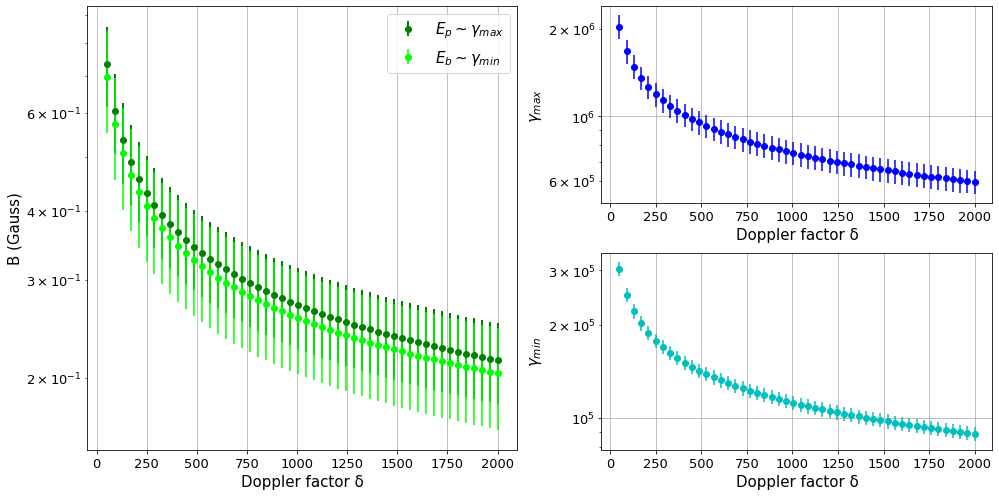

In [142]:
figD = plt.figure(figsize=(14,7))
gs = fig.add_gridspec(2, 2, width_ratios=[1.1, 1], height_ratios=[1, 1])

ax1 = figD.add_subplot(gs[:, 0])
ax1.set_xlabel("Doppler factor δ", fontsize=15)
ax1.set_ylabel("B (Gauss)", fontsize=15)
ax1.grid()
ax1.set_yscale("log")
ax1.tick_params(axis='both', which='both', labelsize=13)
ax1.errorbar(D_array,Bmax_i,yerr=Bmaxer_i, fmt='o', elinewidth=2.0, c='g',label="$E_p \sim \gamma_{max}$")
ax1.errorbar(D_array,Bmin_i,yerr=Bminer_i, fmt='o', elinewidth=1.5, c='lime',label="$E_b \sim \gamma_{min}$")
ax1.legend(fontsize=15)
ax2 = figD.add_subplot(gs[0, 1])
ax2.set_xlabel("Doppler factor δ", fontsize=15)
ax2.set_ylabel("$\gamma_{max}$", fontsize=15)
ax2.grid()
ax2.set_yscale("log")
ax2.tick_params(axis='both', which='both', labelsize=13)
ax2.errorbar(D_array,gmax_i,yerr=gmaxer_i, fmt='o', elinewidth=1.5, c='b')
#ax2.legend(fontsize=15)
ax3 = figD.add_subplot(gs[1, 1])
ax3.set_xlabel("Doppler factor δ", fontsize=15)
ax3.set_ylabel("$\gamma_{min}$", fontsize=15)
ax3.grid()
ax3.set_yscale("log")
ax3.tick_params(axis='both', which='both', labelsize=13)
ax3.errorbar(D_array,gmin_i,yerr=gminer_i, fmt='o', elinewidth=1.5, c='c')
#ax3.legend(fontsize=15)
plt.tight_layout()
#plt.savefig('GRB211211A_SpectralBreaks_correlation.png')

Next Steps: How can we fit both spectral breaks simultaneously? <br>
            How can we find out if $γ_{min}(t)$ OR $γ_{min}$ is the better choice for $E_b$?

Answers: MCMC, AIC criterion (Part2b)